In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pmdarima.arima import auto_arima

In [2]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

In [3]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

def adjust(val, length= 6): return str(val).ljust(length)

### Data Filtering

In [4]:
covid_hospitalization_data = pd.read_csv("/Users/alex/Documents/Covid_Data/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv")
covid_hospitalization_data["date"] = pd.to_datetime(covid_hospitalization_data["date"])
covid_hospitalization_data.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage,Demo | State Geographic Boundaries
0,OR,2021-02-26,1,56,7,2,55,7,9.0,62,...,0,NaN,0,NaN,0,45.0,48,102.0,48,NaN
1,KS,2021-02-24,14,133,3,17,130,3,3.0,147,...,0,NaN,0,NaN,0,47.0,147,219.0,147,NaN
2,NH,2021-02-17,5,24,1,6,23,1,2.0,30,...,0,NaN,0,NaN,0,27.0,16,39.0,16,NaN
3,MA,2021-01-30,10,90,1,11,89,1,83.0,100,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
4,ND,2021-01-30,16,33,2,16,33,2,30.0,50,...,0,NaN,0,NaN,0,33.0,6,65.0,6,NaN


In [5]:
MA_data = covid_hospitalization_data[covid_hospitalization_data['state']=='MA'].sort_values('date')
MA_data.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage,Demo | State Geographic Boundaries
15475,MA,2020-03-27,0,0,1,0,0,1,0.0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
17144,MA,2020-03-28,0,0,1,0,0,1,0.0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
15869,MA,2020-03-29,0,0,2,0,0,2,0.0,2,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
20763,MA,2020-03-30,0,0,6,0,0,6,0.0,5,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN
16094,MA,2020-03-31,0,0,11,0,0,11,0.0,9,...,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN


In [6]:
target_variable = ['total_adult_patients_hospitalized_confirmed_covid']

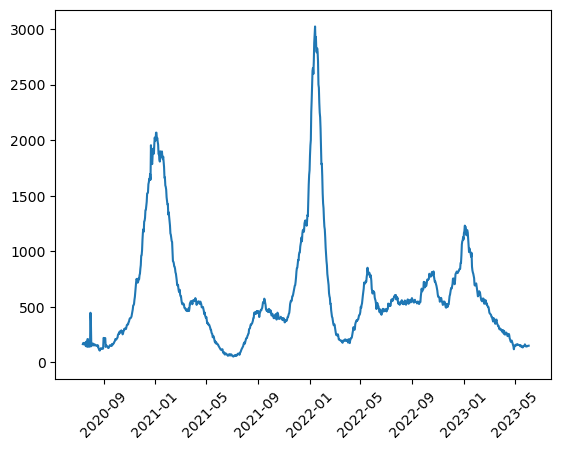

In [7]:
plt.plot(MA_data['date'],MA_data[target_variable])
plt.xticks(rotation=45)
plt.show()

### Seasonality Check

In [8]:
## Model based on previous day admission adult data
pa_MA_data = MA_data[["date",target_variable[0]]]
pa_MA_data.set_index('date',inplace=True)
pa_MA_data.shape

(1164, 1)

In [9]:
pa_MA_data = pa_MA_data.dropna()
pa_MA_data.shape

(1056, 1)

In [10]:
pa_MA_data.head()

,total_adult_patients_hospitalized_confirmed_covid
date,
2020-07-02,0.0
2020-07-14,165.0
2020-07-15,175.0
2020-07-16,176.0
2020-07-17,164.0


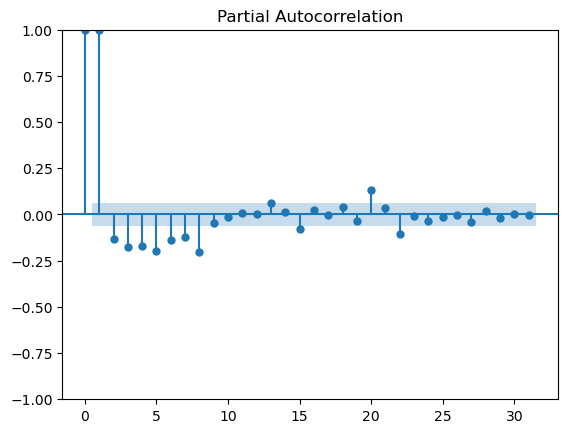

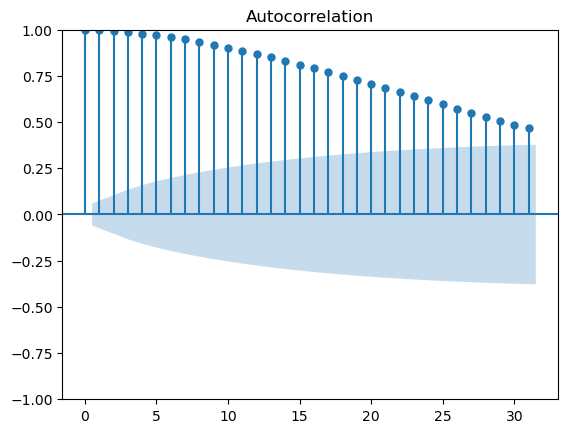

In [11]:
plot_pacf(pa_MA_data[target_variable]);
plot_acf(pa_MA_data[target_variable]);

In [12]:
ad_fuller_result = adfuller(pa_MA_data[target_variable])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.829344655765284
p-value: 0.0026209533925389992


### Baseline Daily ARIMA Model using Auto-ARIMA

In [13]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(pa_MA_data)

(0.01, False)

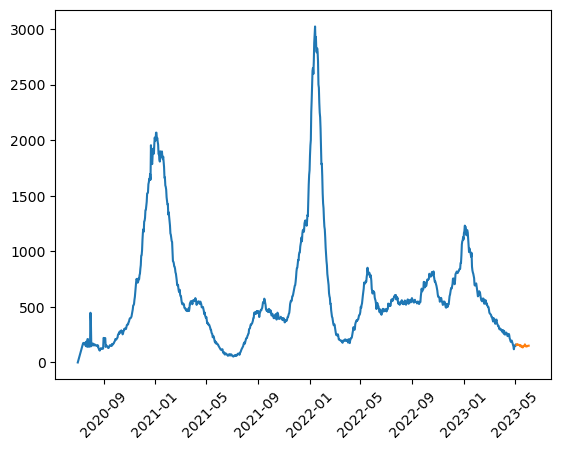

In [14]:
test_size = 30

train = pa_MA_data[:-test_size ]
test = pa_MA_data[-test_size :]
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

In [15]:
arima_model = auto_arima(train,
                        m = 7,
                         seasonal= True,
                         error_action='warn',
                         trace=True,
                         stepwise=True,
                         random_state=20,
                         n_fits=50
                        )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=10117.038, Time=1.24 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=15730.483, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16645.048, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=10148.348, Time=0.76 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=10117.021, Time=0.91 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=10065.601, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=10237.605, Time=0.29 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=10067.818, Time=0.49 sec
 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=10237.322, Time=0.63 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=10267.178, Time=0.15 sec
 ARIMA(1,0,3)(0,0,0)[7] intercept   : AIC=10215.648, Time=0.46 sec
 ARIMA(3,0,1)(0,0,0)[7] intercept   :

In [16]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1026
Model:             SARIMAX(5, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -4976.286
Date:                                Mon, 05 Jun 2023   AIC                           9974.572
Time:                                        17:26:34   BIC                          10028.839
Sample:                                             0   HQIC                          9995.172
                                               - 1026                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3178      0.231      1.373      0.170      -0.136       0.771
ar.L1          1.6431      0.054     30.659      0.000       1.538       1.748
ar.L2         -0.6129      0.058    -10.541      0.000      -0.727      -0.499
ar.L3          0.0122      0.038      0.318      0.751      -0.063       0.087
ar.L4          0.1210      0.053      2.285      0.022       0.017       0.225
ar.L5         -0.1691      0.031     -5.403      0.000      -0.230      -0.108
ma.L1         -0.6183      0.052    -11.937      0.000      -0.720      -0.517
ar.S.L7        0.8990      0.060     14.910      0.000       0.781       1.017
ma.S.L7       -0.6695      0.068     -9.806      0.000      -0.803      -0.536
ma.S.L14      -0.1093      0.032     -3.469      0.001      -0.171      -0.048
sigma2       924.4191     14.208     65.065      0.000     896.573     952.266
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             23564.46
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.31   Skew:                             1.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
prediction, confint = arima_model.predict(n_periods=len(test),
                                          return_conf_int = True)

prediction

/Users/alex/opt/anaconda3/envs/seir/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alex/opt/anaconda3/envs/seir/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1026    160.949191
1027    161.228930
1028    174.873287
1029    187.785955
1030    197.436400
1031    201.251821
1032    210.182633
1033    215.946804
1034    222.493985
1035    237.120678
1036    250.837373
1037    261.217285
1038    267.699651
1039    276.570014
1040    283.580671
1041    290.921393
1042    305.432058
1043    318.716066
1044    328.875194
1045    335.361992
1046    343.842687
1047    350.468098
1048    357.234704
1049    370.303071
1050    382.134580
1051    391.026694
1052    396.496209
1053    403.646347
1054    409.025318
1055    414.435763
dtype: float64

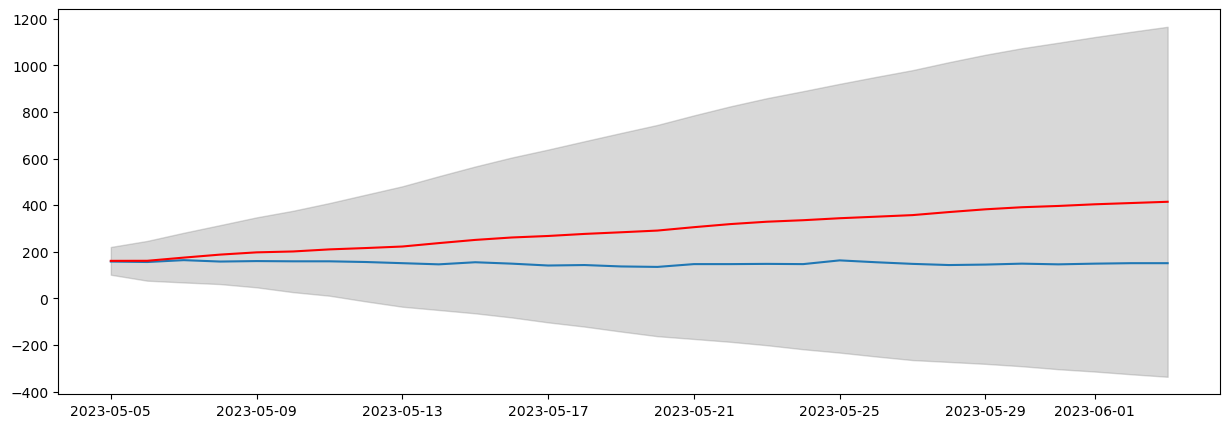

In [18]:
cf= pd.DataFrame(confint)

prediction_series = pd.DataFrame(prediction).set_index(test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(pa_MA_data[target_variable][-test_size:])
ax.plot(prediction_series[-test_size:],
       color = 'red')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [19]:
print('Forecast Accuracy of: total_adult_patients_hospitalized_confirmed_covid')
accuracy_prod = forecast_accuracy(prediction.values, pa_MA_data['total_adult_patients_hospitalized_confirmed_covid'][-test_size:].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))
    

Forecast Accuracy of: total_adult_patients_hospitalized_confirmed_covid
mape   :  0.9434
me     :  139.7032
mae    :  139.7032
mpe    :  0.9434
rmse   :  162.5673
corr   :  -0.4487
minmax :  0.4313


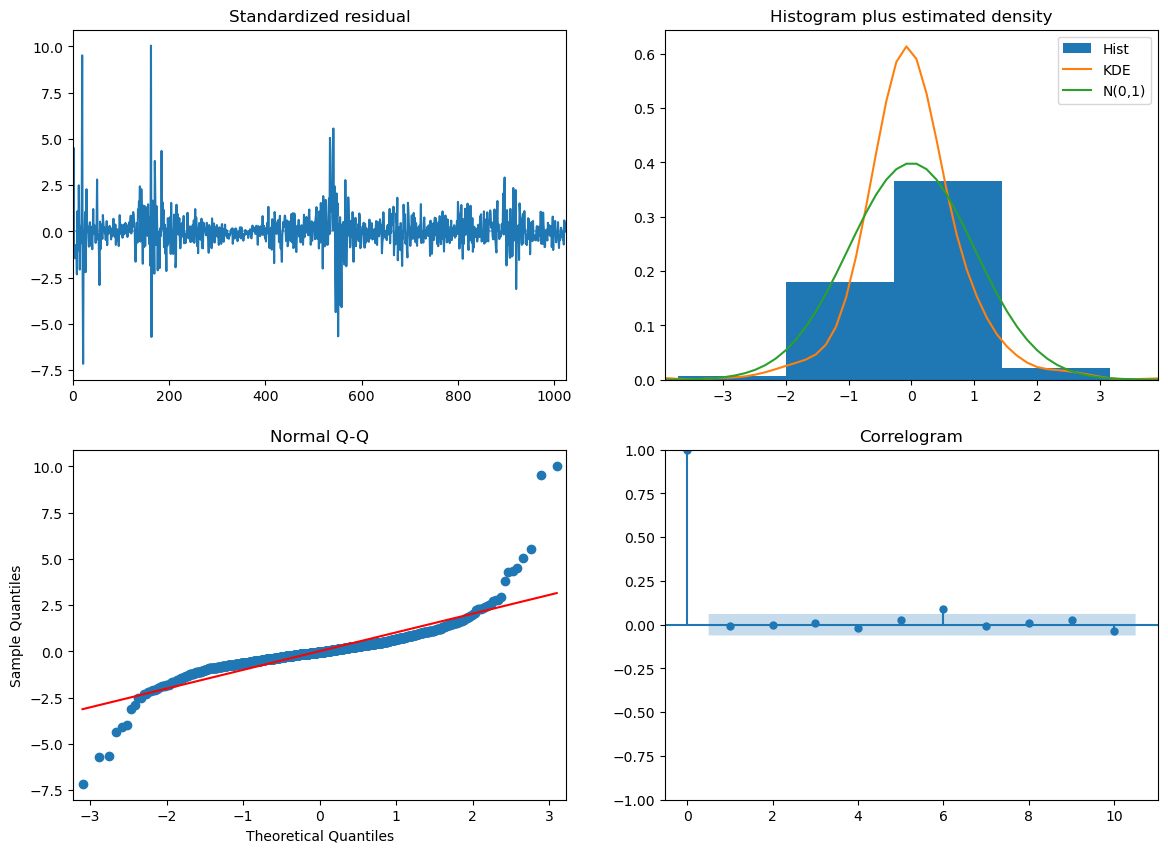

In [20]:
arima_model.plot_diagnostics(figsize=(14,10))
plt.show()

### Baseline Weekly ARIMA Model using Auto-ARIMA

In [21]:
weekly_pa_MA_data = pd.DataFrame()

weekly_pa_MA_data[target_variable] = pa_MA_data[target_variable].diff(7)

weekly_pa_MA_data.index = pa_MA_data.index

weekly_pa_MA_data = weekly_pa_MA_data.dropna()

weekly_pa_MA_data

,total_adult_patients_hospitalized_confirmed_covid
date,
2020-07-20,168.0
2020-07-21,-18.0
2020-07-22,12.0
2020-07-23,-18.0
2020-07-24,-22.0
...,...
2023-05-30,1.0
2023-05-31,-1.0
2023-06-01,-14.0


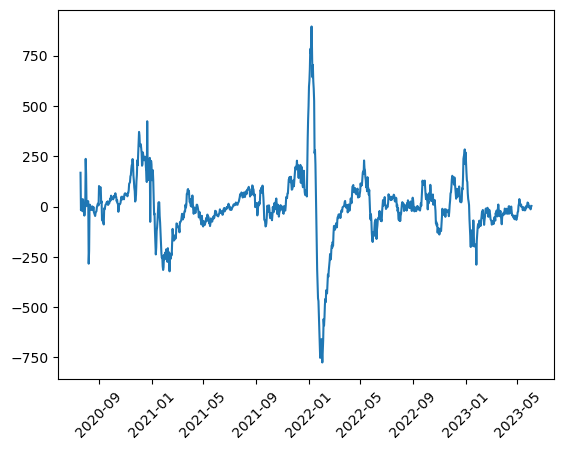

In [22]:
plt.plot(weekly_pa_MA_data[target_variable])
plt.xticks(rotation=45)
plt.show()

In [23]:
ad_fuller_result = adfuller(weekly_pa_MA_data[target_variable])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.766473851536464
p-value: 6.301288063343188e-05


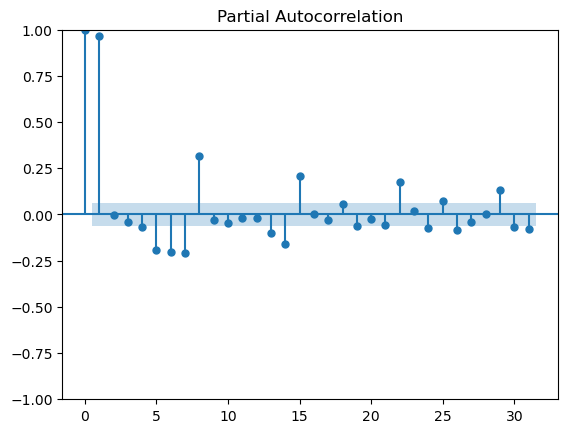

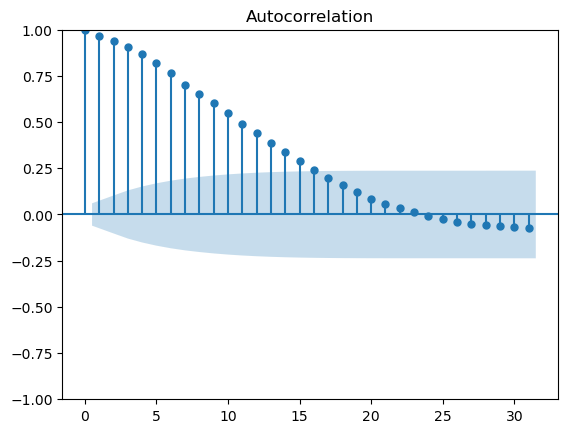

In [24]:
plot_pacf(weekly_pa_MA_data[target_variable]);
plot_acf(weekly_pa_MA_data[target_variable]);

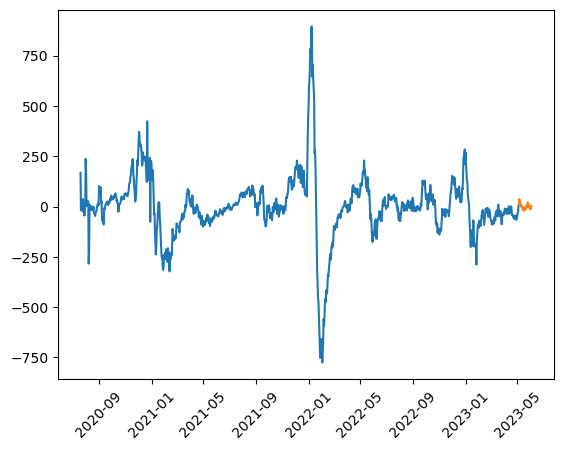

In [25]:
train = weekly_pa_MA_data[:-test_size]
test = weekly_pa_MA_data[-test_size:]
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

In [26]:
weekly_arima_model = auto_arima(train,
                                m=4,
                         seasonal= True,
                         error_action='warn',
                         trace=True,
                         stepwise=True,
                         random_state=20,
                         n_fits=50
                        )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[4] intercept   : AIC=10367.144, Time=0.95 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=13236.614, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=10364.267, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=11492.930, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=13234.614, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=10399.174, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=10362.878, Time=0.55 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=10363.789, Time=0.52 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=10364.269, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=11611.941, Time=0.24 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=10364.811, Time=0.59 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=10364.809, Time=0.68 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=10940.734, Time=0.95 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=10365.366, Time=0.66 sec
 ARIMA(1,0,0)(2,0,0

In [27]:
weekly_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1019
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 4)   Log Likelihood               -5176.449
Date:                           Mon, 05 Jun 2023   AIC                          10360.898
Time:                                   17:26:43   BIC                          10380.604
Sample:                               07-20-2020   HQIC                         10368.381
                                    - 05-04-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9537      0.006    151.263      0.000       0.941       0.966
ar.S.L4        0.1869      0.027      6.859      0.000       0.133       0.240
ar.S.L8        0.0590      0.019      3.182      0.001       0.023       0.095
sigma2      1508.7167     22.947     65.747      0.000    1463.741    1553.693
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12024.23
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
prediction, confint = weekly_arima_model.predict(n_periods=len(test),
                                          return_conf_int = True)

prediction

2023-05-05     3.091878
2023-05-06     6.428163
2023-05-07     5.312187
2023-05-08    11.033432
2023-05-09    10.309587
2023-05-10    11.587031
2023-05-11    10.997777
2023-05-12    13.245738
2023-05-13    12.549748
2023-05-14    12.501644
2023-05-15    11.864449
2023-05-16    12.182176
2023-05-17    11.589902
2023-05-18    11.256189
2023-05-19    10.720807
2023-05-20    10.548919
2023-05-21    10.050167
2023-05-22     9.654029
2023-05-23     9.200783
2023-05-24     8.886418
2023-05-25     8.471230
2023-05-26     8.103768
2023-05-27     7.726418
2023-05-28     7.408558
2023-05-29     7.064109
2023-05-30     6.745630
2023-05-31     6.432425
2023-06-01     6.148533
2023-06-02     5.863265
2023-06-03     5.594765
Freq: D, dtype: float64

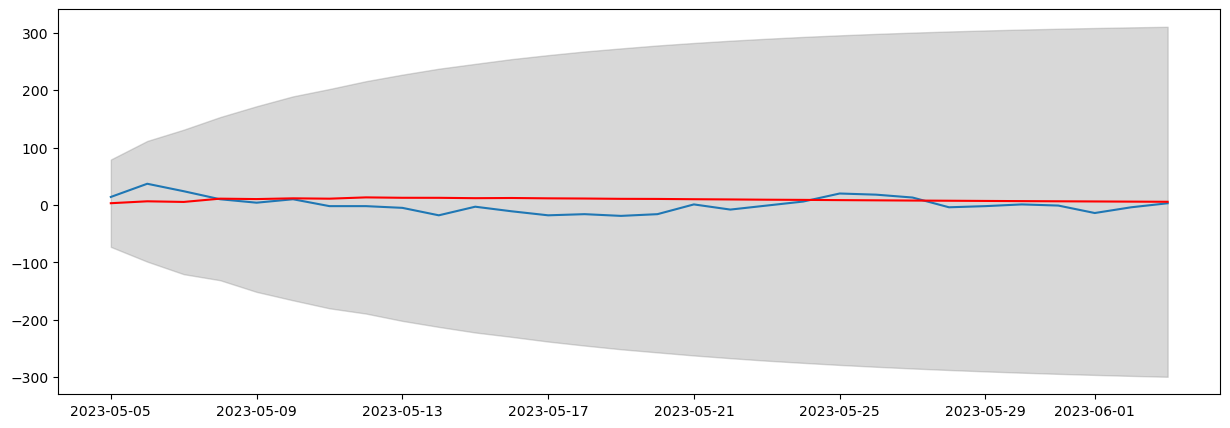

In [29]:
cf= pd.DataFrame(confint)

prediction_series = pd.DataFrame(prediction).set_index(test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(weekly_pa_MA_data[target_variable][-test_size:])
ax.plot(prediction_series[-test_size:],
       color = 'red')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [30]:
print('Forecast Accuracy of: total_adult_patients_hospitalized_confirmed_covid')
accuracy_prod = forecast_accuracy(prediction.values, weekly_pa_MA_data['total_adult_patients_hospitalized_confirmed_covid'][-test_size:].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: total_adult_patients_hospitalized_confirmed_covid
mape   :  2.8662
me     :  8.519
mae    :  14.3101
mpe    :  -1.6674
rmse   :  16.9569
corr   :  -0.4744
minmax :  1.2922


### Baseline Monthly ARIMA Model using Auto-ARIMA

In [31]:
monthly_pa_MA_data = pd.DataFrame()

monthly_pa_MA_data[target_variable] = pa_MA_data[target_variable].diff(30)

monthly_pa_MA_data.index = pa_MA_data.index

monthly_pa_MA_data = monthly_pa_MA_data.dropna()

monthly_pa_MA_data

,total_adult_patients_hospitalized_confirmed_covid
date,
2020-08-12,155.0
2020-08-13,-8.0
2020-08-14,-22.0
2020-08-15,-24.0
2020-08-16,-10.0
...,...
2023-05-30,9.0
2023-05-31,-2.0
2023-06-01,-7.0


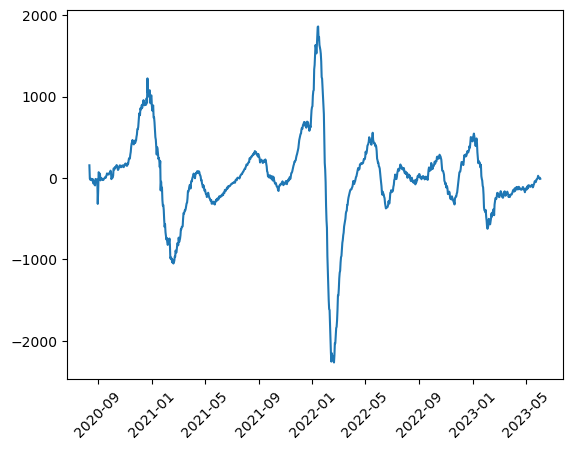

In [32]:
plt.plot(monthly_pa_MA_data[target_variable])
plt.xticks(rotation=45)
plt.show()

In [33]:
ad_fuller_result = adfuller(monthly_pa_MA_data[target_variable])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -4.8407671993841275
p-value: 4.541706423657559e-05


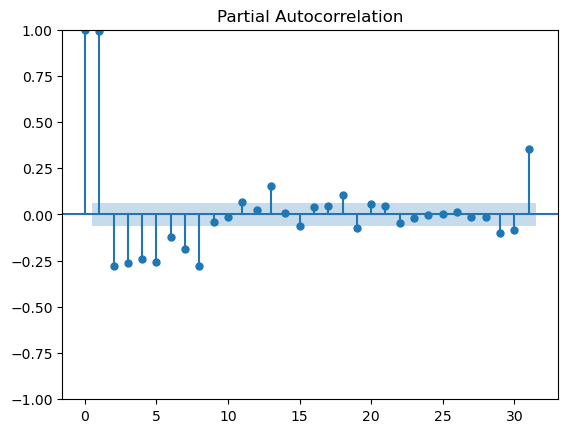

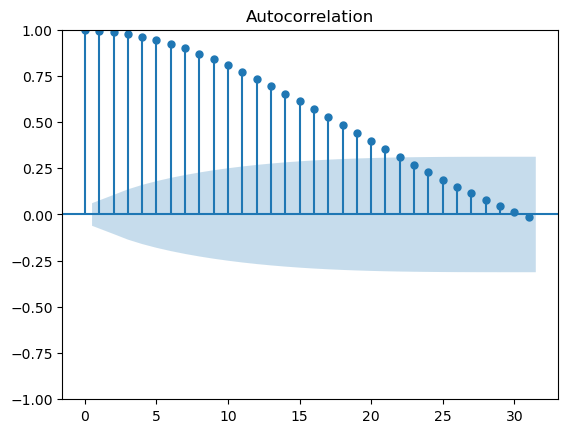

In [34]:
plot_pacf(monthly_pa_MA_data[target_variable]);
plot_acf(monthly_pa_MA_data[target_variable]);

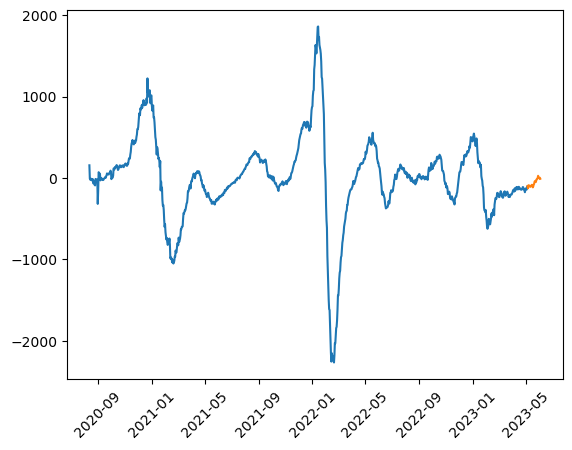

In [35]:
train = monthly_pa_MA_data[:-test_size]
test = monthly_pa_MA_data[-test_size:]
plt.plot(train)
plt.plot(test)
plt.xticks(rotation=45)
plt.show()

In [36]:
monthly_arima_model = auto_arima(train,
                                m=12,
                         seasonal= True,
                         error_action='warn',
                         trace=True,
                         stepwise=True,
                         random_state=20,
                         n_fits=50
                        )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.44 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=15306.316, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=15304.320, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=14549.152, Time=0.31 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=13971.642, Time=1.27 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=13840.914, Time=1.54 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=14033.086, Time=0.54 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=13775.402, Time=4.20 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=13785.601, Time=1.92 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=5.62 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=4.27 sec
 ARIMA(0,0,0)(2,0,2)[12]             : AI

In [37]:
monthly_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                   
=====================================================================================
Dep. Variable:                             y   No. Observations:                  996
Model:             SARIMAX(2, 0, [1, 2], 12)   Log Likelihood               -6881.701
Date:                       Mon, 05 Jun 2023   AIC                          13773.401
Time:                               17:27:23   BIC                          13797.920
Sample:                           08-12-2020   HQIC                         13782.722
                                - 05-04-2023                                         
Covariance Type:                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.4269      0.048      8.966      0.000       0.334       0.520
ar.S.L24      -0.1726      0.033     -5.295      0.000      -0.237      -0.109
ma.S.L12       1.1555      0.043     26.623      0.000       1.070       1.241
ma.S.L24       0.5883      0.040     14.670      0.000       0.510       0.667
sigma2      5.675e+04   1352.885     41.947      0.000    5.41e+04    5.94e+04
===================================================================================
Ljung-Box (L1) (Q):                 777.00   Jarque-Bera (JB):              1603.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
prediction, confint = monthly_arima_model.predict(n_periods=len(test),
                                          return_conf_int = True)

prediction

2023-05-05   -116.302384
2023-05-06    -92.339949
2023-05-07    -27.849520
2023-05-08    -35.447436
2023-05-09   -112.108038
2023-05-10   -111.207510
2023-05-11   -190.408138
2023-05-12   -108.244911
2023-05-13    -67.039993
2023-05-14   -110.939650
2023-05-15    -80.205483
2023-05-16    -31.063967
2023-05-17    -75.829246
2023-05-18    -64.856160
2023-05-19    -24.262088
2023-05-20      2.336055
2023-05-21    -74.645053
2023-05-22    -60.103239
2023-05-23   -121.421261
2023-05-24    -36.685743
2023-05-25     21.020196
2023-05-26    -36.843501
2023-05-27     -7.103413
2023-05-28     28.998435
2023-05-29    -12.294539
2023-05-30    -11.746857
2023-05-31     -5.550106
2023-06-01      7.117326
2023-06-02    -12.513118
2023-06-03     -6.460197
Freq: D, dtype: float64

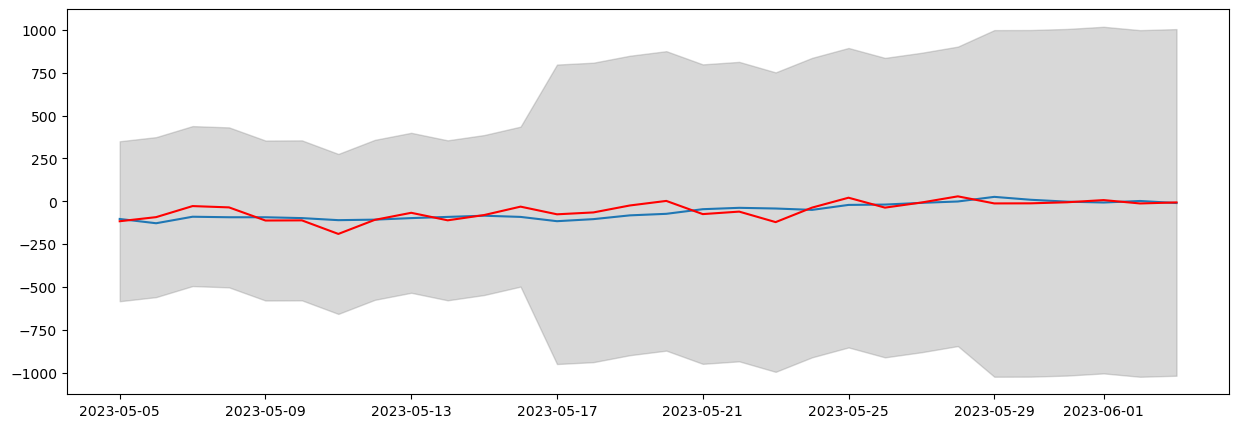

In [39]:
cf= pd.DataFrame(confint)

prediction_series = pd.DataFrame(prediction).set_index(test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(monthly_pa_MA_data[target_variable][-test_size:])
ax.plot(prediction_series[-test_size:],
       color = 'red')
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [40]:
monthly_pa_MA_data[target_variable]['total_adult_patients_hospitalized_confirmed_covid'].values

array([155.,  -8., -22., ...,  -7.,   2., -10.])

In [41]:
print('Forecast Accuracy of: total_adult_patients_hospitalized_confirmed_covid')
accuracy_prod = forecast_accuracy(prediction.values, monthly_pa_MA_data['total_adult_patients_hospitalized_confirmed_covid'][-test_size:].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: total_adult_patients_hospitalized_confirmed_covid
mape   :  1.9396
me     :  6.5
mae    :  31.3219
mpe    :  -1.4569
rmse   :  39.0989
corr   :  0.6824
minmax :  0.9896
